
[Etapa 1: Detección de Estabilidad...]
    --> REPOSO DETECTADO en el Frame 67

[Visualización del Frame Estático 67]


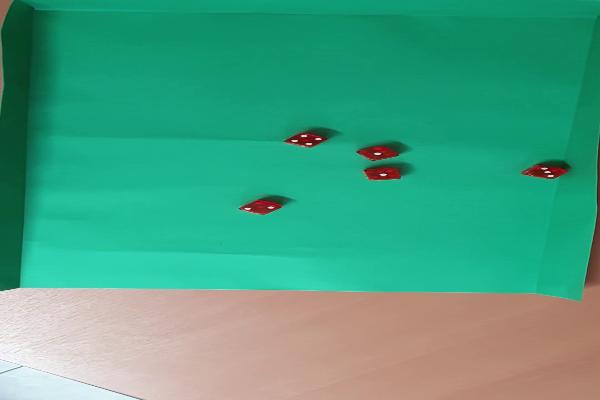


[Etapa 2: Reconocimiento de Valor (Pips)]
    --> Dado 13 localizado en (430,1110) con valor: 2
    --> Dado 14 localizado en (654,933) con valor: 1
    --> Dado 15 localizado en (938,916) con valor: 3
    --> Dado 16 localizado en (642,812) con valor: 1
    --> Dado 17 localizado en (510,738) con valor: 4

--- RESULTADOS DE LA TIRADA 1 ---
Frames Estáticos Confirmados desde el Frame: 67
Valores obtenidos: [2, 1, 3, 1, 4]
Suma Total: 11
-----------------------------------

[Etapa 3: Generando Video Anotado: tirada_1_anotado.mp4]
    --> ¡Video anotado generado con éxito!


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # Para mostrar imágenes en Colab

# --- CONFIGURACIÓN AJUSTADA ---
VIDEO_FILE = 'tirada_1.mp4'
# Parámetros ajustados para mayor estabilidad:
UMBRAL_MOVIMIENTO = 1000  # Reducido de 5000 a 2000: Menos píxeles en movimiento permitidos
FRAMES_ESTABLES = 10      # Aumentado de 10 a 20: Más frames consecutivos requeridos para confirmar reposo

# --- FUNCIONES DE PROCESAMIENTO ---

def detectar_frames_estaticos(video_path):
    """Detecta el primer índice de frame donde los dados se detienen."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error al abrir el video: {video_path}")
        return None

    prev_gray = None
    conteo_estables = 0
    frame_idx = 0
    frame_estatico_detectado = None

    print("\n[Etapa 1: Detección de Estabilidad...]")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (21, 21), 0)

        if prev_gray is not None:
            # 1. Cálculo de la Diferencia de Frames
            frame_delta = cv2.absdiff(prev_gray, gray)
            thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]
            movimiento_puntos = np.sum(thresh == 255)

            if movimiento_puntos < UMBRAL_MOVIMIENTO:
                conteo_estables += 1
            else:
                conteo_estables = 0

            # 2. Confirmación de Reposo
            if conteo_estables == FRAMES_ESTABLES and frame_estatico_detectado is None:
                frame_estatico_detectado = frame_idx - FRAMES_ESTABLES + 1
                print(f"    --> REPOSO DETECTADO en el Frame {frame_estatico_detectado}")
                # Seguimos procesando para llegar al final, pero ya tenemos el índice
                # Podrías agregar 'break' aquí si quieres optimizar y el video es muy largo
                # pero mantener el bucle asegura que no haya un movimiento posterior.

        prev_gray = gray
        frame_idx += 1

    cap.release()
    return frame_estatico_detectado

def reconocer_dados(frame_estatico):
    """Localiza los dados y cuenta los pips en un frame estático."""

    # 1. Segmentación de Dados (Filtro por Color Rojo en HSV)
    hsv = cv2.cvtColor(frame_estatico, cv2.COLOR_BGR2HSV)

    # Rango de Color Rojo (requiere dos rangos en HSV)
    # Ajusta estos valores si tus dados no son de color rojo puro
    mask1 = cv2.inRange(hsv, np.array([0, 100, 100]), np.array([10, 255, 255]))
    mask2 = cv2.inRange(hsv, np.array([160, 100, 100]), np.array([180, 255, 255]))
    mask_dados = cv2.bitwise_or(mask1, mask2)

    # Mejorar la máscara con Morfología (cierre de huecos y suavizado)
    kernel = np.ones((5,5), np.uint8)
    mask_dados = cv2.dilate(mask_dados, kernel, iterations=2)
    mask_dados = cv2.erode(mask_dados, kernel, iterations=1)

    # 2. Encontrar contornos de los dados
    contornos_dados, _ = cv2.findContours(mask_dados, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    dados_detectados = [] # Lista de ((x, y, w, h), valor)

    print("\n[Etapa 2: Reconocimiento de Valor (Pips)]")

    for i, contorno_dado in enumerate(contornos_dados):
        area = cv2.contourArea(contorno_dado)
        if 1500 < area < 50000: # Ajuste según el tamaño esperado de un dado
            x, y, w, h = cv2.boundingRect(contorno_dado)
            dado_roi = frame_estatico[y:y+h, x:x+w]

            # 3. Contar Pips (Puntos Blancos)
            dado_gray = cv2.cvtColor(dado_roi, cv2.COLOR_BGR2GRAY)

            # Umbralizar para aislar los puntos blancos (pips)
            _, mask_pips = cv2.threshold(dado_gray, 200, 255, cv2.THRESH_BINARY)

            # Encontrar contornos de los pips
            pips_contornos, _ = cv2.findContours(mask_pips, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            valor_dado = 0
            for contorno_pip in pips_contornos:
                # Filtrar blobs muy pequeños (ruido)
                if cv2.contourArea(contorno_pip) > 50: # Ajusta 50 si detecta demasiado ruido
                    valor_dado += 1

            dados_detectados.append(((x, y, w, h), valor_dado))
            print(f"    --> Dado {i+1} localizado en ({x},{y}) con valor: {valor_dado}")

    return dados_detectados

def generar_video_con_bbox(video_path, frame_idx_inicio_estatico, dados_detectados):
    """Genera un nuevo video con Bounding Boxes y valores."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return

    # Preparar el escritor de video
    fps = cap.get(cv2.CAP_PROP_FPS)
    ancho = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    alto = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    base_name = video_path.replace(".mp4", "")
    output_filename = f"{base_name}_anotado.mp4"

    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec para MP4
    out = cv2.VideoWriter(output_filename, fourcc, fps, (ancho, alto))

    frame_idx = 0
    print(f"\n[Etapa 3: Generando Video Anotado: {output_filename}]")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Solo aplicar anotaciones cuando los dados están en reposo
        if frame_idx >= frame_idx_inicio_estatico:
            for i, ((x, y, w, h), valor) in enumerate(dados_detectados):
                # Bounding Box (Rectángulo)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 3) # Amarillo

                # Etiqueta y Valor (Texto)
                etiqueta = f"Dado {i+1}: {valor}"
                cv2.putText(frame, etiqueta, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        out.write(frame)
        frame_idx += 1

    print(f"    --> ¡Video anotado generado con éxito!")
    out.release()
    cap.release()

# --- EJECUCIÓN DEL ALGORITMO ---

# 1. Detección de Estabilidad
frame_idx_estatico = detectar_frames_estaticos(VIDEO_FILE)

if frame_idx_estatico is not None:
    # 2. Cargar el frame estático
    cap = cv2.VideoCapture(VIDEO_FILE)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_estatico)
    ret, frame_estatico = cap.read()
    cap.release()

    if ret:
        print(f"\n[Visualización del Frame Estático {frame_idx_estatico}]")
        # Mostrar imagen estática (útil para depuración en Colab)
        # Nota: La visualización puede ser lenta o no funcionar fuera de entornos como Google Colab
        cv2_imshow(cv2.resize(frame_estatico, (600, 400)))

        # 3. Reconocimiento de Dados
        dados_detectados_finales = reconocer_dados(frame_estatico.copy())

        # 4. Mostrar Resultados Finales
        valores_obtenidos = [valor for _, valor in dados_detectados_finales]
        suma_total = sum(valores_obtenidos)

        print("\n--- RESULTADOS DE LA TIRADA 1 ---")
        print(f"Frames Estáticos Confirmados desde el Frame: {frame_idx_estatico}")
        print(f"Valores obtenidos: {valores_obtenidos}")
        print(f"Suma Total: {suma_total}")
        print("-----------------------------------")

        # 5. Generar el Video Anotado
        generar_video_con_bbox(VIDEO_FILE, frame_idx_estatico, dados_detectados_finales)

    else:
        print(f"Error: No se pudo leer el frame {frame_idx_estatico}")
else:
    print(f"\nResultado: No se detectaron frames estáticos en {VIDEO_FILE}.")